Loading weights for net_encoder
Loading weights for net_decoder
scene=scene1


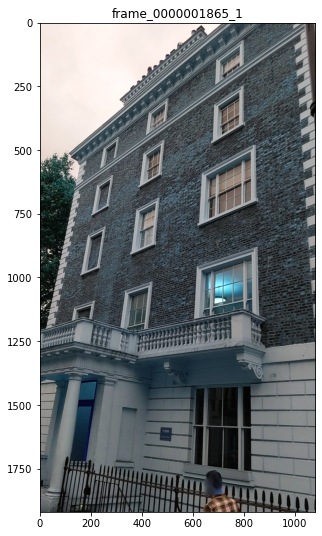

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


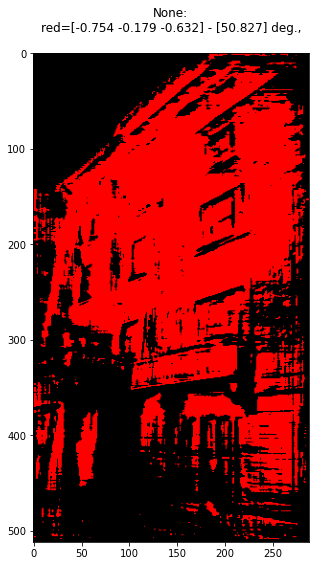

/Users/vaclav/miniconda3/envs/SVP/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([xs, ys, zs, np.ones_like(xs)])


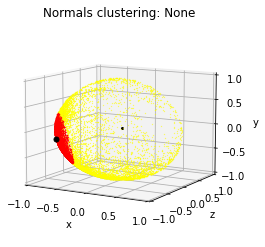

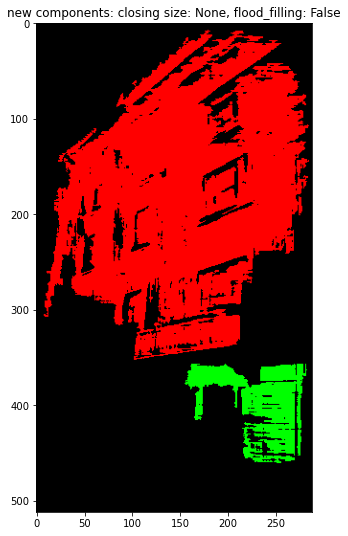

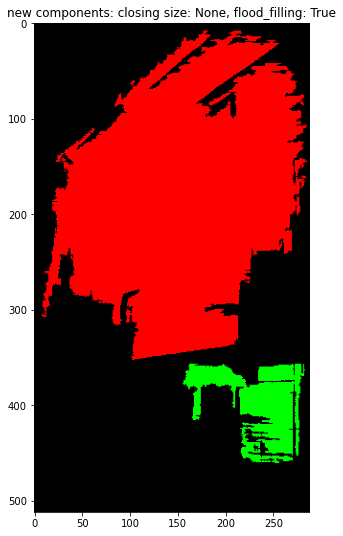

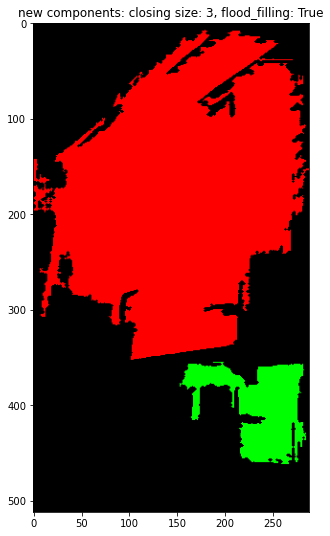

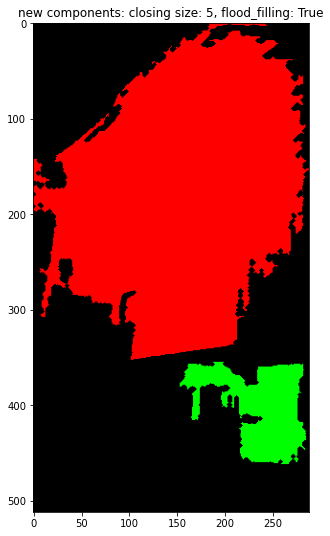

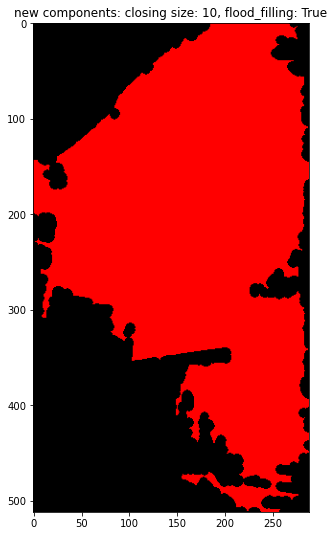

In [1]:
%matplotlib inline
from pipeline import *
from connected_components import *


def filter_valid_normals(normals_clusters_repr, plane_threshold_degrees=75):

    valid_normal_indices_list = []
    for i, normal in enumerate(normals_clusters_repr):
        angle_rad = math.acos(np.dot(normal, np.array([0, 0, -1])))
        angle_degrees = angle_rad * 180 / math.pi
        if angle_degrees >= plane_threshold_degrees:
            continue
        else:
            valid_normal_indices_list.append(i)
    return valid_normal_indices_list


def compute_clusters(img_name):

        scene_info = SceneInfo.read_scene("scene1")
        
        img_file_path = scene_info.get_img_file_path(img_name)
        img = cv.imread(img_file_path, None)

        plt.figure(figsize=(9, 9))
        plt.title(img_name)
        plt.imshow(img)
        show_or_close(True)

        depth_data_file_name = "{}.npy".format(img_name)
        focal_length = (img.shape[0] + img.shape[1]) * 0.5
        
        normals = compute_only_normals(focal_length, img.shape[0], img.shape[1], scene_info.depth_input_dir(), depth_data_file_name)
        filter_mask = get_nonsky_mask(img, normals.shape[0], normals.shape[1])

        #show_sky_mask(img, filter_mask, img_name, show=True, save=False, path=None)

        normals_clusters_repr, normal_indices = cluster_normals(normals, filter_mask=filter_mask)

        show_or_save_clusters(normals,
                      normal_indices,
                      normals_clusters_repr,
                      None,
                      None,
                      show=True,
                      save=False)

        valid_normal_indices = filter_valid_normals(normals_clusters_repr)
        
        return img, normal_indices, valid_normal_indices, normals_clusters_repr

    
def connect_and_show(img, 
                     normal_indices, 
                     valid_normal_indices, 
                     normals_clusters_repr, 
                     closing_size, 
                     flood_filling,
                     connectivity):

    components_indices_new, valid_components_dict_new = get_connected_components(normal_indices, 
                                                                                 valid_normal_indices,
                                                                                 flood_filling=flood_filling,
                                                                                 closing_size=closing_size,
                                                                                 connectivity=connectivity)
    components_indices_new = components_indices_new.astype(dtype=np.uint8)
    #components_indices_new = possibly_upsample_normals(img, components_indices_new)
    get_and_show_components(components_indices_new,
                            valid_components_dict_new,
                            title="new components: closing size: {}, flood_filling: {}".format(closing_size, flood_filling),
                            normals=normals_clusters_repr,
                            show=True,
                            save=False)

        
img_name = "frame_0000001865_1"
img, normal_indices, valid_normal_indices, normals_clusters_repr = compute_clusters(img_name)
connect_and_show(img, normal_indices, valid_normal_indices, normals_clusters_repr, closing_size=None, flood_filling=False, connectivity=8)
connect_and_show(img, normal_indices, valid_normal_indices, normals_clusters_repr, closing_size=None, flood_filling=True, connectivity=8)
connect_and_show(img, normal_indices, valid_normal_indices, normals_clusters_repr, closing_size=3, flood_filling=True, connectivity=8)
connect_and_show(img, normal_indices, valid_normal_indices, normals_clusters_repr, closing_size=5, flood_filling=True, connectivity=8)
connect_and_show(img, normal_indices, valid_normal_indices, normals_clusters_repr, closing_size=10, flood_filling=True, connectivity=8)

